Advantages;<br>
SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm.<br>
They also use less memory because they use a subset of training points in the decision phase.<br>
SVM works well with a clear margin of separation and with high dimensional space.<br>

Disadvantages;<br>
SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes.<br>
It works poorly with overlapping classes and is also sensitive to the type of kernel used.

## Loading Data

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#Loading the Dataframe from Feature_Extraction.ipynb
Dataset = pd.read_pickle("Data_te_std.pkl")
Attack_label = pd.read_pickle("Attack_label.pkl")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   arp.opcode              157800 non-null  float64
 1   arp.hw.size             157800 non-null  float64
 2   icmp.checksum           157800 non-null  float64
 3   icmp.seq_le             157800 non-null  float64
 4   http.content_length     157800 non-null  float64
 5   http.request.method     157800 non-null  float64
 6   http.referer            157800 non-null  float64
 7   http.request.version    157800 non-null  float64
 8   http.response           157800 non-null  float64
 9   tcp.ack                 157800 non-null  float64
 10  tcp.ack_raw             157800 non-null  float64
 11  tcp.checksum            157800 non-null  float64
 12  tcp.connection.fin      157800 non-null  float64
 13  tcp.connection.rst      157800 non-null  float64
 14  tcp.connection.syn  

## Relationship and Parameter estimation

<Axes: >

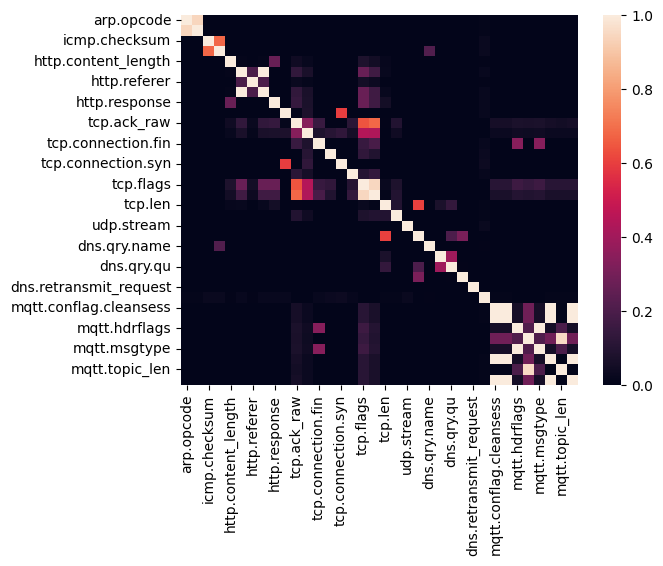

In [5]:
corr_Data = Dataset.corr(method="pearson") 
sns.heatmap(corr_Data, annot=False, vmax=1, vmin=0)

* the corr values shows that some Features are strongly correlated

Pairplot; Features with negative Correlation Value below -0.3.

In [4]:
df = corr_Data.le(-0.4) # boolean Data
positions = np.array([]) 

for label, col in df.items(): # df.items is an iterator over columns
    for index, data in col.items(): # interation of each column gives index 
        if((data==True) & (index != label)):
                positions = np.append(arr= positions, values= [index], axis=0)

print(np.unique(positions))


['dns.qry.name.len' 'dns.retransmission' 'tcp.connection.syn' 'tcp.flags'
 'tcp.flags.ack']


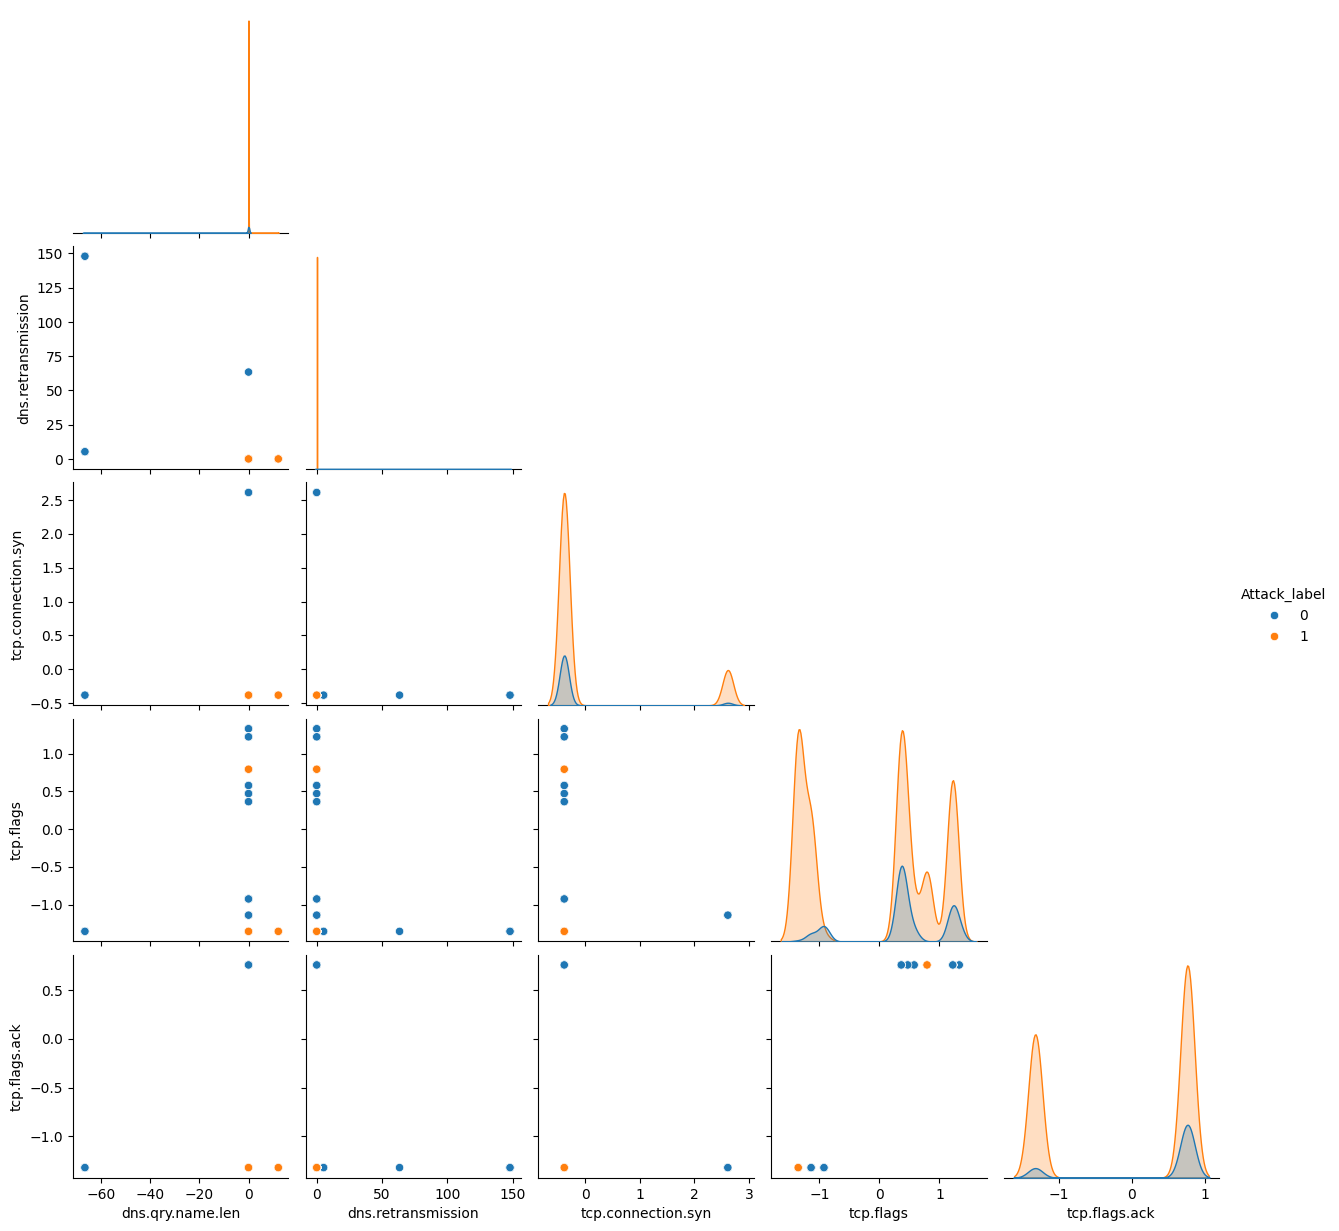

In [56]:
df = Dataset.join(Attack_label)
sns.pairplot(data= df, hue= 'Attack_label', vars= np.unique(positions), corner= True)

* From the Graphs (Pairplots) it is evident that the Features **cannot** be seperated from each other by a hyperplane.
Hence a kernel is needed. 

***

## Reducing the Dataset

In [5]:
# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset.shape[0],Dataset.shape[0]/8 , random_state=22)
Dataset_short = pd.DataFrame(Dataset.loc[indices.tolist()])
Attack_label_short = pd.DataFrame(Attack_label.loc[indices.tolist()])

In [6]:
# Checking distribution before and after sampling
print("Before sampling: ", Attack_label.value_counts(normalize=True))
print("After sampling: ", Attack_label_short.value_counts(normalize=True))

Before sampling:  Attack_label
1    0.846001
0    0.153999
Name: proportion, dtype: float64
After sampling:  Attack_label
1               0.847909
0               0.152091
Name: proportion, dtype: float64


## SMOTEENN Oversampling

In [8]:
from imblearn.combine import SMOTEENN
sm = SMOTEENN(random_state= 22)
Dataset_res, Target_res = sm.fit_resample(Dataset_short, Attack_label_short)
print("Target Shape: ", Attack_label_short.shape)
print("Resampled Target Shape: ", Target_res.shape)

print(Attack_label_short.value_counts(normalize = True))
print(Target_res.value_counts(normalize = True))

Target Shape:  (19725, 1)
Resampled Target Shape:  (25801, 1)
Attack_label
1               0.847909
0               0.152091
Name: proportion, dtype: float64
Attack_label
0               0.50688
1               0.49312
Name: proportion, dtype: float64


In [10]:
X = Dataset_res.to_numpy()
Yl = Target_res.to_numpy(dtype='int')

## Train Test split

In [11]:
# Splitting for calculating Hyperparameter
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.8, random_state=22)

## Hyperparameter

Deciding Parameters are Kernel and C. (if 'poly' kernel also d = degree)

Random Search

In [12]:
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
svc = svm.SVC()
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[100, 500]} # parameter grid
rand_eval = RandomizedSearchCV(svc, parameters, cv=2)
search = rand_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search.best_params_)
print("Best score: ", search.best_score_)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Hyperparameters:  {'kernel': 'rbf', 'C': 500}
Best score:  0.9015503875968992


Grid Search

In [63]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[150, 200, 500],}
svc = svm.SVC()
grid_eval = GridSearchCV(svc, parameters, cv=2)
search_grid = grid_eval.fit(X_train,Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Hyperparameters:  {'C': 500, 'kernel': 'rbf'}
Best score:  0.9095518150476577


* From Randomsearch and Gridsearch it is evident that,<br>
For **Normalised Dataset** kernel as **poly with a degree of 3 (default) and C of higher value is optimal**.<br>
For **Standardised Dataset** Kernel as **rbf and C of higher value is optimal**.<br>

Higher Value of C means low regularisation, smaller margin, strict classification.
Lower is opposite ofc.

In [13]:
from sklearn.model_selection import validation_curve
C_param = [1, 500, 1000, 3000]
svc = svm.SVC(kernel='rbf')
train_score, test_score = validation_curve(svc, X_train, Y_train, param_name= 'C', param_range= C_param, cv=3)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

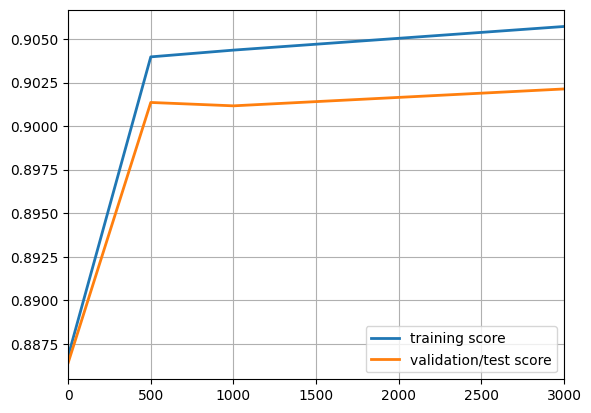

In [14]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 3000))
plt.legend()
plt.show()

* Through Validation_curve 
For **normalised Dataset the maximum value of C is found to be 500** after which the test score precedes training score. So C=400 is concluded as Hyperparameter. <br>
For **standardised Dataset the maximum value of C could be 1000** after which Overfitting might occur.


Number of Samples Evaluation

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

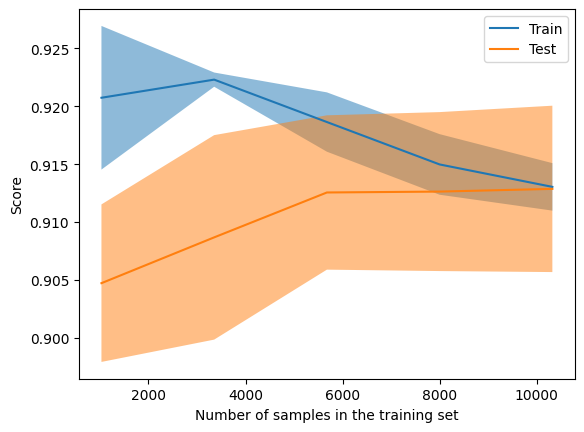

In [15]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22)
svc = svm.SVC(kernel='rbf', C=1000)
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, Y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

* For the **Normalised Dataset with Hyperparameter (kernel = poly, degree = 3, C = 400)** the model could be trained well enough from just around **3000 samples**. <br>
For the **Standardised Dataset with Hyperparameter (kernel = rbf, C=1000)** the model could be trained only with **8000 samples**.

## SVC with Standardised Dataset

In [16]:
from sklearn import svm
X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')
# we need only around 8000 samples so test and training ratio can be only 0.3 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.6, random_state=22) 
svc = svm.SVC(kernel='rbf', C=1000)
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evluation Metrics

Accuracy: 0.9108584716749564
Precision: 0.9741787624140565
Recall: 0.8403848688546197
F1 Score: 0.9023492782337956


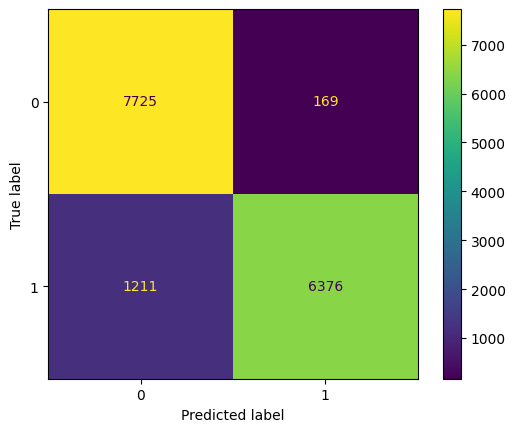

In [17]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

* Modal have a good F1 Rate, which means good trade off between bias and variance. 

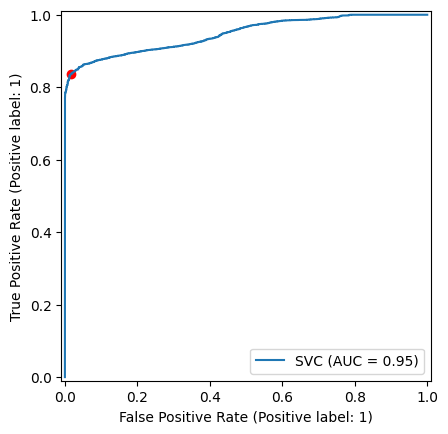

In [18]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')

* AUROC shows a good value of 0.86, which means that the modal is good at predicting both positive and negative labels.
Low Threshhold value (Red dot) says that the modal will classify more instances as positive (hence more TPR) otherswise called high sensitivity. Moving Threshold right increase Specificity increases and decreases Sensitivity.

## PCA Evaluation

In [26]:
from sklearn.decomposition import PCA
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22) 
pca = PCA(n_components=30)
pca.fit_transform(X_train)

array([[ 2.19734500e+01, -1.47172555e+00, -8.28561678e-01, ...,
         5.22058732e-02,  1.94315753e-05, -5.79646790e-15],
       [-8.52520020e-01, -7.34430394e-01,  3.08352862e-02, ...,
        -1.29006619e-01, -1.95423640e-05,  3.54443726e-15],
       [-8.32724633e-01, -7.04577149e-01,  2.84668680e-02, ...,
        -1.11748583e-01,  3.21034787e-05,  6.28133789e-16],
       ...,
       [-1.08179482e+00, -1.22644071e+00,  7.12745153e-02, ...,
        -1.22571305e-03, -1.56330234e-05,  3.07365434e-17],
       [-1.13690012e+00, -1.28934972e+00,  7.96511641e-02, ...,
         5.04807600e-02, -7.67533660e-05, -1.35841533e-15],
       [ 1.66238993e+00,  9.95862884e+00,  1.15979242e+01, ...,
         2.91303820e-02, -1.56484953e-05, -7.29178138e-15]])

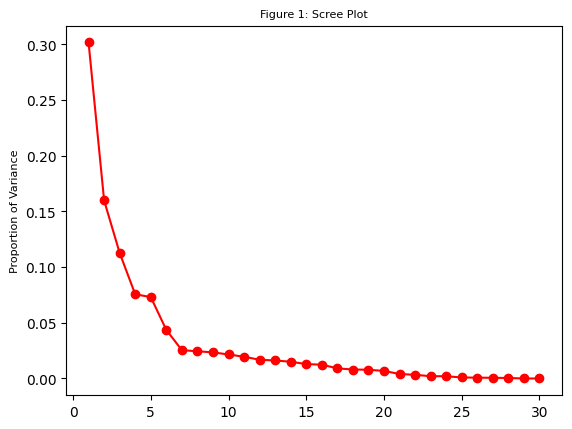

In [27]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, prop_var, 'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

Kaiser's rule is based on keeping the components with eigenvalues greater than 1.

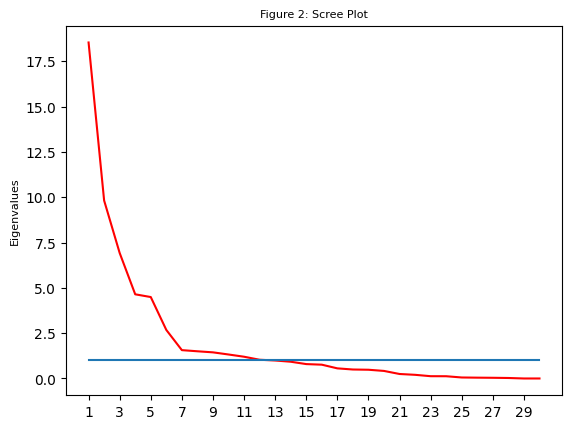

In [29]:
plt.plot(PC_numbers, eigenvalues, 'r')
plt.plot(PC_numbers, np.ones(30))
plt.title('Figure 2: Scree Plot', fontsize=8)
plt.ylabel('Eigenvalues', fontsize=8)
plt.xticks(np.arange(1, 31, 2))
plt.show()

* So the optimal number of Features which could produce the same result as without PCA is just under 15.

## SVC after PCA

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)

X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')

X_PCA = pca.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X_PCA, Yl, test_size=0.6, random_state=22) 

In [23]:
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.9098895420192494
Precision: 0.9741194486983155
Recall: 0.8384078028206142
F1 Score: 0.9011829708861656


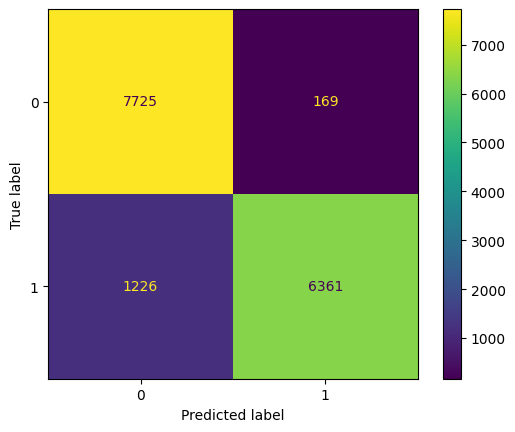

In [24]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

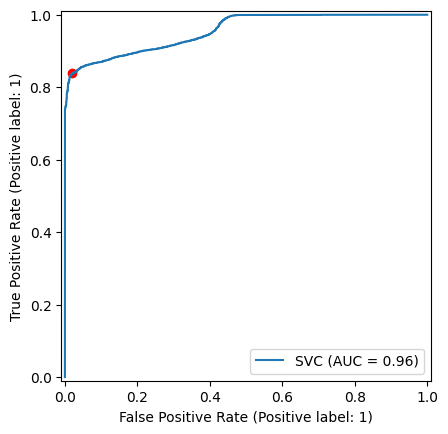

In [25]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')

##  Modal SVC with Normalised Dataset

In [31]:
# loading the normalized dataset
Dataset_norm = pd.read_pickle("Data_te_norm.pkl")
Dataset_norm_short = pd.DataFrame(Dataset_norm.loc[indices.tolist()])

# oversampling the dataset
Dataset_res, Target_res = sm.fit_resample(Dataset_norm_short, Attack_label_short)

X = Dataset_res.to_numpy() # 19725 sample
Yl = Target_res.to_numpy(dtype='int')

# we need only around 3000 samples so test and training ratio can be only 0.2 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.8, random_state=22) 

svc = svm.SVC(kernel='poly', C=400)
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluation

Accuracy: 0.7249727061280676
Precision: 0.9975011358473421
Recall: 0.4315903282877924
F1 Score: 0.6024972557628979


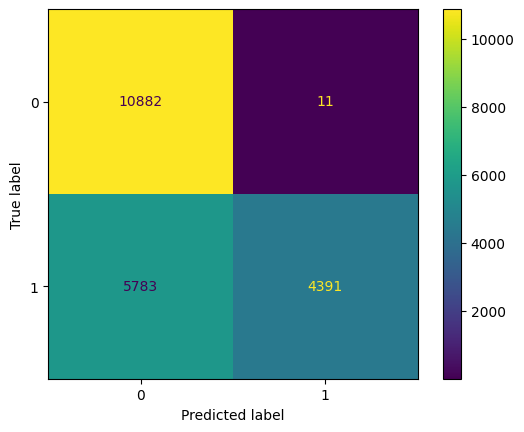

In [32]:
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

* The modal is very good at predicting abnormal Datasample. (Precision = 1)

Best Threshhold:  (0.0017442394198108877, 0.43837232160408884)


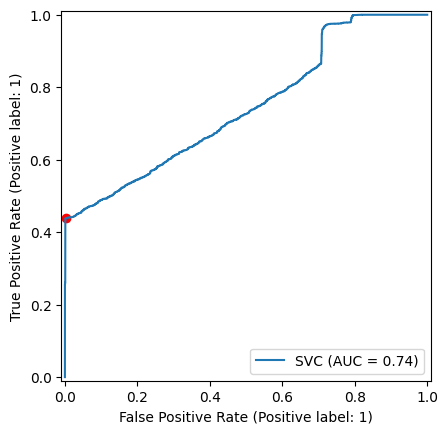

In [33]:
from sklearn.metrics import roc_curve, RocCurveDisplay

Y_score = clf.decision_function(X_test)
fpr, tpr, threshhold = roc_curve(Y_test, Y_score)
RocCurveDisplay.from_estimator(clf, X_test, Y_test)

J = tpr - fpr
best_threshhold_index = np.argmax(J)
best_tpr= tpr[best_threshhold_index]
best_fpr= fpr[best_threshhold_index]
plt.scatter(best_fpr, best_tpr, c = 'red')
print("Best Threshhold: ", (best_fpr, best_tpr))

* Area under ROC is equal to 0.74.<br> 
which means that the model is not good at predicting both positives and negatives.

***

## Conclusion

The Dataset is Loaded and sampled 1/8 of the original dataset with almost same distribution of labels, because for the
SVM algorithm not too many samples are needed. Then with the help of these sampled dataset the modal is validated for Hyperparamters. With Random-Search and Grid-Search the Kernel for the modal is determined. Then with the help of validation-curve optimal value for the C parameter is determined. Finally with Learning Curve minimum number of samples to train a optimum modal is calculated.<br>

**The Result shows that SVC Model of Hyperparameter, C=1000, Kernel=rbf, Samples=4000 produce good accuracy, F1 Score, AUROC, for a standardised Dataset. Through PCA the dimensionality can be reduced to less than half as well as the training time.** <br>

**The result doesnt match the Paper from Edge IIoTset!!**<br>

By Normalised Dataset the SVC gives an undesirable results. (low AUROC)
